**References**

[`%matplotlib inline` Why?](https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline)

# **Imports**

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

**Double Check that the rows between the features and the labels match up. We don't want to have the wrong labels. Numpy's `assert_array_equal` will error if the two arrays—the row indices of the two data frames — don't match up.**

In [84]:
result = np.testing.assert_array_equal(df_features.index.values, df_labels.index.values)

#df_seasonal = df_features.merge(df_labels[['seasonal_vaccine', 'respondent_id']],  left_on='respondent_id', right_on='respondent_id')
#df_h1n1 = df_features.merge(df_labels[['h1n1_vaccine', 'respondent_id']],  left_on='respondent_id', right_on='respondent_id')

# **Exploring the Data - Labels**

Let's start by taking a look at our distribution of the two target variables.

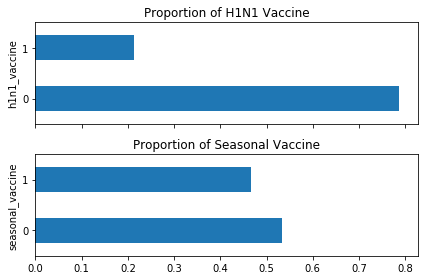

In [85]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = df_labels.shape[0]

(df_labels['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(df_labels['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

**It looks like roughy half of people received the seasonal flu vaccine, but only about `20%` of people received the H1N1 flu vaccine.** 

In terms of class balance, we say that the seasonal flu vaccine target has balanced classes, but the H1N1 flu vaccine target has moderately imbalanced classes.

**Are the two target variables independent? Let's take a look.**

In [86]:
pd.crosstab(
    df_labels["h1n1_vaccine"], 
    df_labels["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


**[Phi Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient)** in statistics is a measure of association for two binary variables. This measure is similar to the Pearson correlation coefficient in its interpretation. In fact, a Pearson correlation coefficient estimated for two binary variables will return the phi coefficient.

**[DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)** Compute pairwise correlation of columns, excluding NA/null values. Methods can be `pearson`, `kendall`, `spearman`. 

**[Pearson vs Kendall vs Spearman](https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall)**

In [87]:
# Phi Coefficient is the same as Pearson for two binary variables
(df_labels["h1n1_vaccine"]
     .corr(df_labels["seasonal_vaccine"], method="pearson")
)

# 0.37714265306144634 - spearman
# 0.37714265306144634 - kendall
# 0.37714265306144495 - pearson

0.37714265306144495

**These two variables have a phi coefficient of `0.37`, indicating a moderate positive correlation.** 

We can see that in the cross-tabulation as well. 

Most people who got an H1N1 flu vaccine also got the seasonal flu vaccine. While a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higher rate than those who did not get the seasonal vaccine.

# **Exploring the Data - Features**

From the problem description page, we know that the feature variables are almost all categorical: a mix of binary, ordinal, and nominal features. Let's pick a few and see how the rates of vaccination may differ across the levels of the feature variables.

In [88]:
joined_df = df_features.join(df_labels)
joined_df.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0


Let's see how the features are correlated with the target variables. We'll start with trying to visualize if there is simple bivariate correlation. If a feature is correlated with the target, we'd expect there to be different patterns of vaccination as you vary the values of the feature.

Jumping right to the right final visualization is hard. 

We can instead pick one feature and one target and work our way up to a prototype, before applying it to more features and both targets. We'll use `h1n1_concern`, the level of concern the person showed about the H1N1 flu, and `h1n1_vaccine` as a target variable.

In [89]:
h1n1_counts = joined_df[['h1n1_concern', 'h1n1_vaccine']].groupby(['h1n1_concern', 'h1n1_vaccine']).size().unstack('h1n1_vaccine')
h1n1_counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


It's hard to eyeball these raw numbers and see patterns clearly. Let's put this into a bar chart. We'll compare how the group sizes change as you vary `h1n1_concern`.

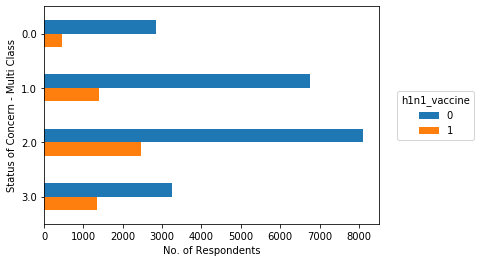

In [90]:
ax = h1n1_counts.plot.barh()
ax.invert_yaxis()
ax.set_ylabel("Status of Concern - Multi Class") # Multi-Class variable
ax.set_xlabel("No. of Respondents")
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title='h1n1_vaccine')

From the plot, we can see that majority of people are not vaccinated (large blues), even if they are very concerned (class 3). Unfortunately, it's still hard to tell whether `h1n1_concern` levels show differences in someone's likelihood to get vaccinated. 

Since the two classes are imbalanced, we just see fewer vaccinated observations for every level of `h1n1_concern`. It swamps out any other trends that might exist.

Let's instead look at the **rate of vaccination** for each level of `h1n1_concern`.

In [91]:
h1n1_concern_counts = h1n1_counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [92]:
props = h1n1_counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


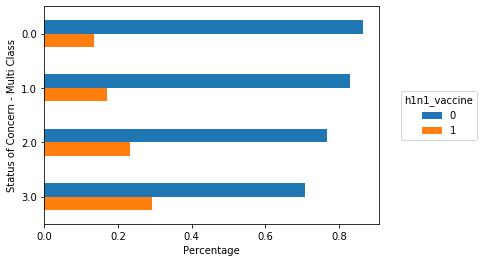

In [93]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.set_ylabel("Status of Concern - Multi Class")
ax.set_xlabel("Percentage")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='h1n1_vaccine')

Now we have a clearer picture of what's happening! In this plot, each pair of blue (no vaccine) and orange (received vaccine) bars add up to 1.0. 

**We can clearly see that even though most people don't get the H1N1 vaccine, they are more likely to if they have a higher level of concern.**

It looks like `h1n1_concern` will be a useful feature when we get to modeling.

Since every pair of bars adds up to 1.0 and we only have two bars, this is actually a good use case for a stacked bar chart, to make it even easier to read.

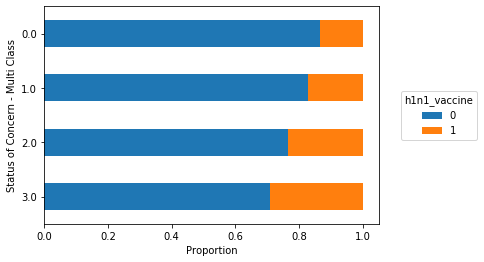

In [94]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.set_ylabel("Status of Concern - Multi Class")
ax.set_xlabel("Proportion")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='h1n1_vaccine')

Let's factor this code into a function so we can use it on more variables. 

Then, we'll loop through several columns and plot against both `h1n1_vaccine` and `seasonal_vaccine`.

In [95]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = joined_df[[target, col]].groupby([target, col]).size().unstack(target)
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.set_ylabel(col)
    ax.set_xlabel("Proportion")
    ax.invert_yaxis()
    ax.legend().remove()

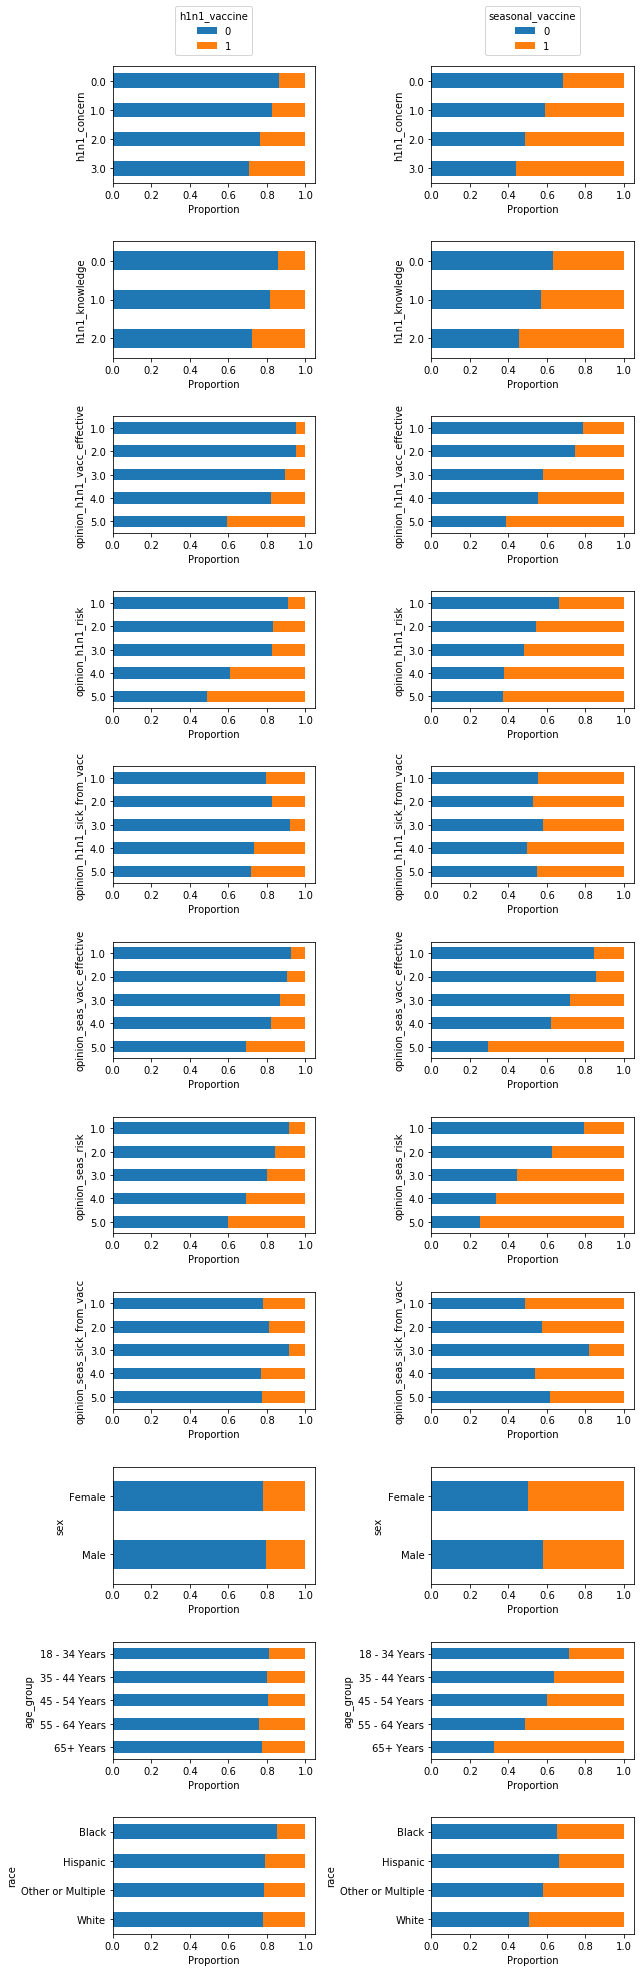

In [96]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))

for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1])
    
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

It looks like the knowledge and opinion questions have pretty strong signal for both target variables.

The demographic features have stronger correlation with `seasonal_vaccine`, but much less so far `h1n1_vaccine`. 

In particular, we interestingly see a strong correlation with `age_group` with the `seasonal_vaccine` but not with `h1n1_vaccine`. 

It appears that with seasonal flu, people act appropriately according to the fact that people [more impacted and have higher risk of flu-related complications with age](https://www.cdc.gov/flu/highrisk/index.htm). 

It turns out though that H1N1 flu has an interesting relationship with age: [even though older people have higher risk of complications, they were less likely to get infected!](https://www.cdc.gov/h1n1flu/surveillanceqa.htm#7) 

While we know anything about causality from this analysis, it seems like the risk factors ended up being reflected in the vaccination rates.

# **Building Some Model**

Let's start working on training some models! We will be using logistic regression, a simple and fast linear model for classification problems. Logistic regression is a great model choice for a first-pass baseline model when starting out on a problem.

Standard logistic regression only works with numeric input for features. Since this is a benchmark, we're going to build simple models only using the numeric columns of our dataset.

Categorical variables with non-numeric values take a little more preprocessing to prepare for many machine learning algorithms. We're not going to deal with them in this benchmark walkthrough, but there are many different ways to encode categorical variables into numeric values. Check out [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) to get started if you're not familiar.

In [97]:
#df_features.dtypes != "object"
numeric_cols = df_features.columns[df_features.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


# **Feature Pre-Processing**

There are two important data preprocessing steps before jumping to the logistic regression:

- **Scaling**: Transform all features to be on the same scale. This matters when using regularization, which we will discuss in the next section. We will use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), also known as Z-score scaling. This scales and shifts features so that they have zero mean and unit variance.

- **NA Imputation**: Logistic regression does not handle NA values. We will use median imputation, which fills missing values with the median from the training data, implemented with [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

We are also going to start using Scikit-Learn's built-in composition functionality to encapsulate everything into a pipeline. Building pipelines is a best practice for building machine learning models. Among [other benefits](https://scikit-learn.org/stable/modules/compose.html), it makes it easy to reuse on new data (such as our test data). The great thing about pipelines is that they have the same interface as transformers and estimators, so you can treat them as if they are.

We're going to first chain together the preprocessing steps (scaling and imputing) into one intermediate pipeline object `numeric_preprocessing_steps`. Then, we use that with Scikit-Learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), which is a convenient way to grab columns out of a pandas data frame and then apply a specified transformer.

If we wanted to do other transformations on other columns, such as encoding our non-numeric columns, that would be additional entries to the list in the `transformers` argument of `ColumnTransformer`.

In [98]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

Next, we're going to define our estimators.

We'll use scikit-learn's default hyperparameters for `LogisticRegression` of L2 (a.k.a. Ridge) regularization with `C` value (inverse regularization strength) of 1. [Regularization](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a) is useful because it reduces overfitting. Check out scikit-learn's documentation for `LogisticRegression` to read more about the options. When building your own model, you may want to tune your hyperparameters using something like [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Because we have two labels we need to predict, we can use Scikit-Learn's [`MultiOutputClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html). This is a convenient shortcut for training two of the same type of model and having them run together.

# **Estimator**

In [99]:
estimators = MultiOutputClassifier(estimator=LogisticRegression(penalty="l2", C=1))

# **Putting Together the Full Pipeline**

We put the preprocessing and the estimator stages together into one Pipeline object, which gives us one interface to run data through for everything.

In [100]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [101]:
full_pipeline

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standard_scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                 

# **Training & Evaluation**

Finally, let's get ready to train and evaluate our model.

Let's split our available data into a training and evaluation set. (We're going to reserve "test set" to refer to the final predictions we upload to the platform.) We'll use a third of our data for evaluation.

Recall that earlier in our exploratory analysis, the `h1n1_vaccine` label classes were moderately imbalanced. Sometimes this can lead to lopsided splits, which can lead to generalization problems with fitting and/or evaluating the model. We should have a large enough dataset that a randomly shuffled split should keep the same proportions, but we can use the `stratify` argument to enforce even splits.

In [102]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df_features,
    df_labels,
    test_size=0.33,
    shuffle=True,
    stratify=df_labels,
    random_state=RANDOM_SEED
)

In [105]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)

print(preds)

[array([[0.70898963, 0.29101037],
       [0.9022304 , 0.0977696 ],
       [0.84459811, 0.15540189],
       ...,
       [0.92338263, 0.07661737],
       [0.89632521, 0.10367479],
       [0.92787943, 0.07212057]]), array([[0.52721977, 0.47278023],
       [0.61838467, 0.38161533],
       [0.37024394, 0.62975606],
       ...,
       [0.85936904, 0.14063096],
       [0.77843342, 0.22156658],
       [0.15115096, 0.84884904]])]
CPU times: user 228 ms, sys: 35.3 ms, total: 264 ms
Wall time: 101 ms


In [106]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


This has given us back a list of two (n_obs, 2) arrays. 

The first array is for `h1n1_vaccine`, and the second array is for `seasonal_vaccine`. 

The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays. Let's grab those and put them in a data frame.

In [107]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291010,0.472780
16516,0.097770,0.381615
3106,0.155402,0.629756
16981,0.661791,0.857876
19111,0.284478,0.776927


This competition uses [ROC AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) as the metric. Let's plot ROC curves and take a look. Unfortunately, scikit-learn's convenient [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) doesn't support multilabel, so we'll need to make the plot ourselves.

In [108]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

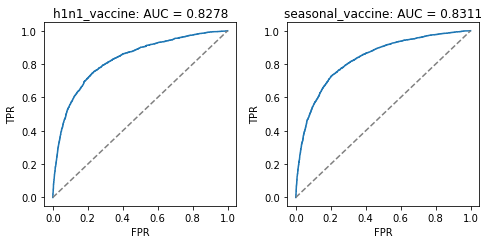

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

An AUC score of `0.5` is no better than random, and an AUC score of 1.0 is a perfect model. Both models look like they generally perform similarly. Our scores of around 0.83 are not great, but they're not bad either!

The competition metric is the average between these two AUC values. Scikit-learn's [`roc_auc_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) does support multilabel, so we can use that directly.

In [110]:
roc_auc_score(y_eval, y_preds)

0.8294712007285718

# **Retrain Model on Full Dataset**

Now that we have an idea of our performance, we'll want to retrain our model on the full dataset before generating our predictions on the test set.

In [111]:
%%time 

full_pipeline.fit(df_features, df_labels)

None   # So we don't print out the whole pipeline representation

CPU times: user 300 ms, sys: 47.6 ms, total: 348 ms
Wall time: 145 ms


# **Generating The Predictions For The Test Set**

Let's make predictions on the test set! Again, for this competition, we want the probabilities, not the binary label predictions. We'll again use the `.predict_proba` method to get those.

In [112]:
test_features_df = pd.read_csv("data/test_set_features.csv", index_col="respondent_id")
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.87280333, 0.12719667],
        [0.94475602, 0.05524398],
        [0.62906951, 0.37093049],
        ...,
        [0.80411015, 0.19588985],
        [0.9492446 , 0.0507554 ],
        [0.38421362, 0.61578638]]), array([[0.57359831, 0.42640169],
        [0.92876678, 0.07123322],
        [0.3626162 , 0.6373838 ],
        ...,
        [0.59872448, 0.40127552],
        [0.68003071, 0.31996929],
        [0.35787941, 0.64212059]])]

As before, this gives us back two arrays: one for `h1n1_vaccine`, and one for `seasonal_vaccine`. The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays.

Let's read in the submission format file so we can put our predictions into it.

In [113]:
submission_df = pd.read_csv("data/submission_format.csv", index_col="respondent_id")
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


We want to replace those 0.5s and 0.7s with our predictions. 

First, make sure we have the rows in the same order by comparing the indices. Then, we can drop in the appropriate columns from our predicted probabilities.

In [115]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.127197,0.426402
26708,0.055244,0.071233
26709,0.370930,0.637384
26710,0.464351,0.803446
26711,0.286673,0.634903


In [117]:
submission_df.to_csv('data/solution_benchmark_submission.csv', index=True)

!head data/solution_benchmark_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.1271966712294673,0.4264016892401287
26708,0.05524398225067432,0.07123321893591482
26709,0.3709304937253417,0.6373837966869101
26710,0.46435145760248464,0.8034458932944253
26711,0.2866728545814011,0.6349032284619175
26712,0.4078979764484603,0.8902898368065043
26713,0.2726656162847449,0.3305798266931593
26714,0.11837766921319928,0.24030262915206663
26715,0.0305875125852897,0.1486705386009269
